In [1]:
import unittest
import os
import sys
import numpy as np
import igl
import time
import matplotlib.pyplot as plt
import importlib
import random

import rainbow.cuda.geometry.grid3 as CUDAGRID
import rainbow.geometry.grid3 as GRID
import rainbow.geometry.volume_mesh as VM
from numba import cuda

from tqdm import tqdm
import rainbow.math.vector3 as V3
import rainbow.simulators.prox_soft_bodies.api as API
import rainbow.simulators.prox_soft_bodies.solver as SOLVER
import rainbow.util.viewer as VIEWER
from rainbow.util.USD import USD

importlib.reload(API)
importlib.reload(SOLVER)
importlib.reload(CUDAGRID)

<module 'rainbow.cuda.geometry.grid3' from '/home/qbp758/dev/RAINBOW/python/rainbow/cuda/geometry/grid3.py'>

In [36]:
# colors for visualization
v3_colors = [
    V3.make(0.90, 0.10, 0.29),
    V3.make(0.24, 0.71, 0.29),
    V3.make(1.00, 0.88, 0.10),
    V3.make(0.26, 0.39, 0.85),
    V3.make(0.96, 0.51, 0.19),
    V3.make(0.57, 0.11, 0.71),
    V3.make(0.28, 0.94, 0.94),
    V3.make(0.95, 0.20, 0.90),
    V3.make(0.74, 0.96, 0.05),
    V3.make(0.98, 0.74, 0.75),
    V3.make(0.00, 0.50, 0.50),
    V3.make(0.90, 0.75, 1.00),
    V3.make(0.60, 0.39, 0.14),
    V3.make(1.00, 0.98, 0.78),
    V3.make(0.50, 0.00, 0.00),
    V3.make(0.67, 1.00, 0.76),
    V3.make(0.50, 0.50, 0.00),
    V3.make(1.00, 0.85, 0.69),
    V3.make(0.00, 0.00, 0.46),
    V3.make(0.50, 0.50, 0.50),
    V3.make(1.00, 1.00, 1.00),
    V3.make(0.00, 0.00, 0.00)
]


MODEL_MAP = {
    'SVK': API.SVK,
    'COR': API.COR,
    'SNH': API.SNH
}


# create a soft material into a scene
def create_soft_material(engine, name=None, model_name='SVK', friction=0.5):
    model = MODEL_MAP[model_name]
    E, nu, rho = API.create_material_parameters(name) # if name == None, default values , E = 10e5 nu = 0.3 rho = 1000  

    API.create_material(engine, 'soft_mat1')
    API.set_elasticity(engine, 'soft_mat1', E, nu)
    API.set_mass_density(engine, 'soft_mat1', rho)
    API.set_constitutive_model(engine, 'soft_mat1', model)
    API.set_viscosity(engine, 'soft_mat1', 0.5)
    API.create_surfaces_interaction(engine,'soft_mat1','soft_mat1', friction)

# create the soft beam into a scene
def create_soft_beam(engine, geo, gravity=-10, material='soft_mat1', name='beam'):
    V_beam, T_beam = VM.create_beam(*geo) # geometry 
    
    # V_beam[:,0] -= random.uniform(-4.0, -1.5)
    # V_beam[:,1] += random.uniform(0.275, 0.276)
    # V_beam[:,2] -= random.uniform(-1.5, 1.5)
    API.create_soft_body(engine, name, V_beam, T_beam)
    API.set_type(engine, name, "Free")
    API.set_gravity(engine, name, (0,gravity,0))
    API.set_material(engine, name, material)
    return len(T_beam)
    
# create the wall into a scene
def create_wall(engine):
    V_wall, T_wall = VM.create_beam(2, 2, 2, 0.1, 8.0, 8.0)
    V_wall[:,0] -= 2.05
    API.create_soft_body(engine, 'wall', V_wall, T_wall)
    API.set_type(engine, 'wall', "Fixed")
    API.set_gravity(engine, 'wall', (0,0,0))
    API.set_material(engine,'wall','soft_mat1')

# initialize the viewer
def initialize_viewer(engine, viewer, usd):
    # viewer.create_frame("origin")
    for body in engine.bodies.values():    
        opacity = 0.5
        F = VM.to_triangles(body.T)
        color = random.choice(v3_colors)
        viewer.create_mesh(body.name, body.x0, F, color, opacity)   
        # add mesh to usd
        usd.add_mesh(body.name, body.x0, F, color)

    viewer.show()

def simulate(engine, T = 1.0, render_fps=60.0, non_update_bodies=[], update_traction=False):
    sim_dt = engine.params.time_step
    sim_fps = 1.0 / sim_dt
    render_dt = 1 / render_fps
    render_steps = int(np.round(T / render_dt))
    # usd.set_animation_time(T*render_fps) # set the simulation ending time  in usd

    for step in tqdm(range(render_steps), desc="Rendering Loop:"):
        dT = render_dt 
        while dT > 0: # do simulation block
            dt = min(dT, sim_dt) # generally, sim_dt < render_dt
            API.simulate(engine, dt, debug_on=True)
            dT -= dt
            # upadte_viewer(engine, viewer, non_update_bodies)
        # upadte_usd(engine, usd, step*render_dt*render_fps, non_update_bodies)

    return API.get_log(engine)

def plot_profile(cpu_times, gpu_times, xlabel, title='Execution Time Comparison: CPU vs GPU'):
    plt.figure(figsize=(10, 6))
    plt.plot(cpu_times, '-o', label='CPU')
    plt.plot(gpu_times, '-o', label='GPU')
    plt.xlabel(xlabel)
    plt.ylabel('Execution Time (seconds)')
    plt.title(title)
    plt.legend()
    plt.grid(True, which="both", ls="--", c='0.7')
    plt.show()

def get_computing_time(stats):
    time_elastic_forces = [ stats[i]['compute_elastic_forces'] for i in range(1, len(stats)) ]
    time_traction_forces = [ stats[i]['compute_traction_forces'] for i in range(1, len(stats)) ]
    time_damping_forces = [ stats[i]['compute_damping_forces'] for i in range(1, len(stats)) ]
    time_external_forces = [ stats[i]['compute_external_forces'] for i in range(1, len(stats)) ]
    time_update_bvh = [ stats[i]['update_bvh'] for i in range(1, len(stats)) ]
    time_narrow_phase = [ stats[i]['narrow_phase'] for i in range(1, len(stats)) ]
    time_contact_determination = [ stats[i]['contact_determination'] for i in range(1, len(stats)) ]
    time_contact_point_reduction = [ stats[i]['contact_point_reduction'] for i in range(1, len(stats)) ]
    time_collision_detection = [ stats[i]['collision_detection_time'] for i in range(1, len(stats)) ]
    time_stepper = [ stats[i]['stepper_time'] for i in range(1, len(stats)) ]
    time_kinetic_energy = [ stats[i]['compute_kinetic_energy'] for i in range(1, len(stats)) ]
    time_poential_energy = [ stats[i]['compute_potential_energy'] for i in range(1, len(stats)) ]
    time_elastic_energy = [ stats[i]['compute_elastic_energy'] for i in range(1, len(stats)) ]

    time_elastic_forces = np.array(time_elastic_forces)
    time_traction_forces = np.array(time_traction_forces)
    time_damping_forces = np.array(time_damping_forces)
    time_external_forces = np.array(time_external_forces)
    time_update_bvh = np.array(time_update_bvh)
    time_narrow_phase = np.array(time_narrow_phase)
    time_contact_determination = np.array(time_contact_determination)
    time_contact_point_reduction = np.array(time_contact_point_reduction)
    time_collision_detection = np.array(time_collision_detection)
    time_stepper = np.array(time_stepper)
    time_kinetic_energy = np.array(time_kinetic_energy)
    time_poential_energy = np.array(time_poential_energy)
    time_elastic_energy = np.array(time_elastic_energy)

    total_time = time_elastic_forces.sum() + time_traction_forces.sum() + time_damping_forces.sum() + time_external_forces.sum() + time_update_bvh.sum() + time_narrow_phase.sum() + time_contact_determination.sum() + time_contact_point_reduction.sum() + time_collision_detection.sum() + time_stepper.sum() + time_kinetic_energy.sum() + time_poential_energy.sum() + time_elastic_energy.sum()

    total_time_contact_determination = time_contact_determination.sum()

    return total_time, total_time_contact_determination

## Compare the running time of the CUDA and CPU versions of the contact points calculation

The scene is this first soft demo, this is a very easy scene to compute, but it is a good starting point to compare the running time of the CPU and CUDA versions of the contact points calculation.

In [15]:
scene = API.create_engine()
scene.params.time_step = 0.001

create_soft_material(scene, None, 'SNH') 
create_soft_beam(scene, (12, 3, 3, 4.0, 1.0, 1.0))
create_wall(scene)

def left_wall(x):
    return x[0] + 1.9

API.create_dirichlet_conditions(scene, 'beam', left_wall)


# use GPU computing
stats_gpu = simulate(scene,  T = 1, non_update_bodies=['wall'])




Rendering Loop::   0%|          | 0/60 [00:00<?, ?it/s]/home/qbp758/anaconda3/envs/sim/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/home/qbp758/anaconda3/envs/sim/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
Rendering Loop:: 100%|██████████| 60/60 [02:45<00:00,  2.76s/it]


In [16]:
scene_cpu = API.create_engine()
scene_cpu.params.time_step = 0.001

create_soft_material(scene_cpu, None, 'SNH') 
create_soft_beam(scene_cpu, (12, 3, 3, 4.0, 1.0, 1.0))
create_wall(scene_cpu)

def left_wall(x):
    return x[0] + 1.9

API.create_dirichlet_conditions(scene_cpu, 'beam', left_wall)


# use CPU computing
scene_cpu.params.use_gpu = False
stats_cpu = simulate(scene_cpu,  T = 1, non_update_bodies=['wall'])


Rendering Loop:: 100%|██████████| 60/60 [05:36<00:00,  5.61s/it]


In [17]:
time_contact_determination_gpu = [ stats_gpu[i]['contact_determination'] for i in range(1, len(stats_gpu)) ]
time_contact_determination_cpu = [ stats_cpu[i]['contact_determination'] for i in range(1, len(stats_cpu)) ]
time_contact_determination_gpu = np.array(time_contact_determination_gpu)
time_contact_determination_cpu = np.array(time_contact_determination_cpu)

time_contact_determination_gpu.sum() , time_contact_determination_cpu.sum()

(5.177919248118997, 176.0775797739625)

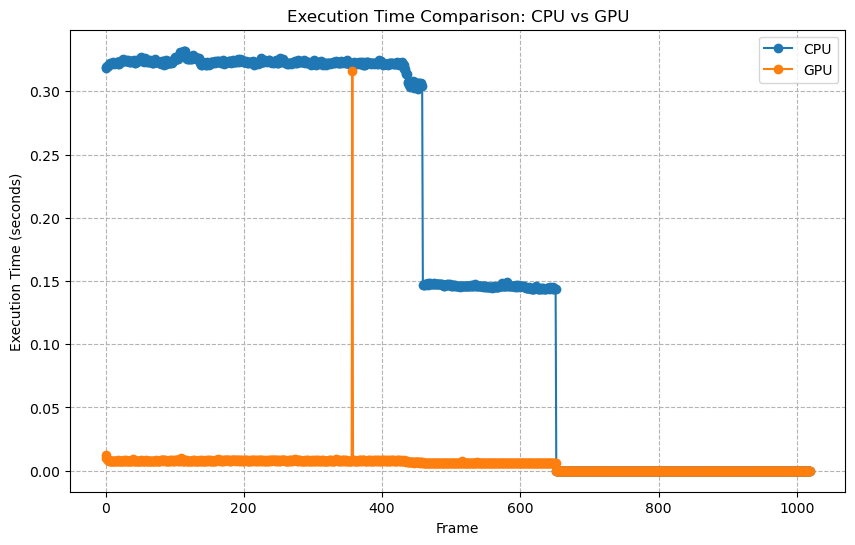

In [18]:


plot_profile(time_contact_determination_cpu, time_contact_determination_gpu, 'Frame', 'Execution Time Comparison: CPU vs GPU')

## Compare the performance of CPU and GPU computing deeply
Now, we will create more complex scenes to compare the performance of CPU and GPU computing deeply.


In [37]:
def create_complex_scene(number_cell = 5, material=None, model='SNH', time_step=0.0001, use_gpu=True):
    scene = API.create_engine()
    scene.params.time_step = time_step
    viewer = VIEWER.Viewer()

    create_soft_material(scene, material, model) 

    T1 = create_soft_beam(scene, (number_cell, number_cell, number_cell, 2, 2, 2), name="cube")
    T2 = create_soft_beam(scene, (number_cell, number_cell, number_cell, 4, 0.05, 4), name="surface")

    API.create_dirichlet_conditions(scene, 'surface', lambda x: x[0] + 1.9)
    API.create_dirichlet_conditions(scene, 'surface', lambda x: 1.9 - x[0])

    usd = USD("complex_scene"+ str(number_cell) +".usd")
    initialize_viewer(scene, viewer, usd)
    usd.save()

    scene.params.use_gpu = use_gpu
    stats = simulate(scene, T = 0.05)
    return stats, T1+T2


In [49]:

number_objects = [2]

stats_gpu = []
stats_cpu = []
number_tets = []

for number in number_objects:
    complex_stats_gpu, number_tet = create_complex_scene(number, use_gpu=True)
    stats_gpu.append(complex_stats_gpu)

    complex_stats_cpu, number_tet = create_complex_scene(number, use_gpu=False)
    stats_cpu.append(complex_stats_cpu)

    number_tets.append(number_tet)

total_time_gpus = []
total_time_cpus = []
total_time_contact_determination_gpus = []
total_time_contact_determination_cpus = []




# for i in range(len(number_objects)):
#     total_time_gpu, total_time_contact_determination_gpu = get_computing_time(stats_gpu[i])
#     total_time_cpu, total_time_contact_determination_cpu = get_computing_time(stats_cpu[i])
#     print("number of tets: ", number_tets[i])
#     print("total time gpu: ", total_time_gpu)
#     print("total time cpu: ", total_time_cpu)
#     print("total time contact determination gpu: ", total_time_contact_determination_gpu)
#     print("total time contact determination cpu: ", total_time_contact_determination_cpu)
#     print("speed up: ", total_time_cpu / total_time_gpu)
#     print("speed up contact determination: ", total_time_contact_determination_cpu / total_time_contact_determination_gpu)

#     stats_cpu[i] = (total_time_cpu, total_time_contact_determination_cpu)
#     stats_gpu[i] = (total_time_gpu, total_time_contact_determination_gpu)

#     total_time_gpus.append(total_time_gpu)
#     total_time_cpus.append(total_time_cpu)
#     total_time_contact_determination_gpus.append(total_time_contact_determination_gpu)
#     total_time_contact_determination_cpus.append(total_time_contact_determination_cpu)

# plt.figure(figsize=(10, 6))
# plt.plot(number_tets, total_time_contact_determination_gpus, '-o', label='GPU (contact determination)')
# plt.plot(number_tets, total_time_contact_determination_cpus, '-o', label='CPU (contact determination)')
# plt.plot(number_tets, total_time_gpus, '-o', label='GPU (total)')
# plt.plot(number_tets, total_time_cpus, '-o', label='CPU (total)')
# plt.xlabel("Number of Tetrahedrons")
# plt.ylabel('Execution Time (seconds)')
# plt.title('Execution Time Comparison: CPU vs GPU')
# plt.legend()
# plt.grid(True, which="both", ls="--", c='0.7')
# plt.show()




Renderer(camera=PerspectiveCamera(aspect=1.25, children=(DirectionalLight(color='white', intensity=0.6, positi…

Rendering Loop:: 100%|██████████| 3/3 [00:08<00:00,  2.81s/it]


Renderer(camera=PerspectiveCamera(aspect=1.25, children=(DirectionalLight(color='white', intensity=0.6, positi…

Rendering Loop:: 100%|██████████| 3/3 [01:02<00:00, 20.97s/it]


In [45]:
number_objects

[2]

IndexError: invalid index to scalar variable.